#  Cancer Detection: Model Selection, Tuning, and Validation

## Task

Perform a predictive modeling analysis on wdbc cancer dataset using the decision tree, k-NN techniques, logistic regression and SVM (explore how well model performs for several different hyper-parameter values). Present a brief overview of your predictive modeling process, explorations, and discuss your results.  Make sure you present information about the model “goodness” (possible things to think about: confusion matrix, predictive accuracy, precision, recall, f-measure). Briefly discuss ROC and lift curves. 

#### Process Overview

We applied nested cross-validation to evaluate and select the best-performing classification model among k-Nearest Neighbors (k-NN), Logistic Regression, Decision Tree, and Support Vector Machine (SVM). The dataset was split into a 70/30 ratio, with 70% used for training and model selection (through cross-validation), and the remaining 30% held out for final performance evaluation.

- Outer Cross-Validation (CV): The outer loop was used to estimate the generalization performance of each model. It mimics real-world model deployment by testing the model on unseen data in each fold.

- Inner Cross-Validation (CV): The inner loop was used for hyperparameter tuning via grid search. Within each outer training fold, the inner CV identifies the best parameter settings that optimize a chosen scoring metric (recall, in our case).

This two-layer approach helps prevent overfitting and ensures a more reliable estimate of each model's ability to generalize.

## Load in Data

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Get headers from website and import through csv, create a list
headers = pd.read_csv('variables.csv', header = None)
h_list = headers.iloc[:, 0].tolist()

# Import data with headers
wdbc = pd.read_csv('wdbc.data', header= None, names= h_list, index_col = 0)

# Change Diagnosis column to string
wdbc['Diagnosis'] = wdbc['Diagnosis'].astype(str)

# Encode Diagnosis: Malignant (M) = 1, Benign (B) = 0
wdbc['Diagnosis'] = wdbc['Diagnosis'].replace('M',1)
wdbc['Diagnosis'] = wdbc['Diagnosis'].replace('B',0)

C:\Users\olivi\AppData\Local\Temp\ipykernel_3164\2258974304.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wdbc['Diagnosis'] = wdbc['Diagnosis'].replace('B',0)


In [8]:
# View the dataset
wdbc.head()

,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
ID,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
# Separate features (X) and target variable (y)
X = wdbc.iloc[:,1:31] 
y = wdbc['Diagnosis']

## Set Up

In [11]:
# Import libraries and packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [12]:
# Split the data into training (70%) and testing (30%) sets
# Only give CV 70% of the data and save 30% to hold out on final tuning and test after CV
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=0.3, random_state=42)

## Run Nested CV on Models

In [14]:
# Create nested cv classifcation function to call later
def nested_cv(model_pipeline, param_grid, X_train, y_train, outer_splits=5, inner_splits=5):

    # Define outer CV for model performance
    outer_cv = StratifiedKFold(n_splits= outer_splits, shuffle=True, random_state=42)

    # Set lists for scores to append later
    accuracy_scores, recall_scores, precision_scores , f1_scores = [], [], [], []

    for train_idx, test_idx in outer_cv.split(X_train, y_train):
        # Split outer train/test data
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Inner CV for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

        # GridSearchCV for tuning
        grid_search = GridSearchCV(model_pipeline, param_grid, cv=inner_cv, scoring='recall', refit=True)
        grid_search.fit(X_train_fold, y_train_fold)

        # Best model from inner loop
        best_model = grid_search.best_estimator_

        # Predict on outer test set
        y_pred = best_model.predict(X_test_fold)

        # Calculate different performance metrics
        accuracy = accuracy_score(y_test_fold, y_pred)
        recall = recall_score(y_test_fold, y_pred)
        precision = precision_score(y_test_fold, y_pred)
        f1 = f1_score(y_test_fold, y_pred)

        # Append scores for each fold
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        f1_scores.append(f1)

    # Return mean metrics across outer folds
    return {
        'Nested CV Accuracy': float(np.mean(accuracy_scores)),
        'Nested CV Recall': float(np.mean(recall_scores)),
        'Nested CV Precision': float(np.mean(precision_scores)),
        'Nested CV F1 Score': float(np.mean(f1_scores))
    }

### KNN

In [16]:
# Create pipelines with normalization (scaling) and models
# Define the model
model_knn = KNeighborsClassifier()

# Create a pipeline with normalization and the model
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('KNN', model_knn)  # KNN classifier
])

# Define the parameter grid for hyperparameter tuning (inner loop)
param_grid_knn = {
    'KNN__n_neighbors': [5, 7, 10, 15],
    'KNN__metric': ['euclidean', 'manhattan'],  # The correct way to pass parameters for KNN
    'KNN__weights': ['uniform', 'distance']
}

results_knn = nested_cv(pipeline_knn, param_grid_knn, X_train_cv, y_train_cv)
print(results_knn)

  File "C:\Users\olivi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\olivi\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\olivi\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\olivi\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


{'Nested CV Accuracy': 0.9523417721518987, 'Nested CV Recall': 0.9064367816091956, 'Nested CV Precision': 0.9655172413793103, 'Nested CV F1 Score': 0.9335930904604195}


### Decision Tree

In [18]:
# Create pipelines with normalization (scaling) and models
# Define the model
model_dt = DecisionTreeClassifier()

# Create a pipeline with the model, no need to normalize on DT
pipeline_dt= Pipeline([
    ('DecisionTree', model_dt)  # Dt classifier
])

# Set parameter grid
param_grid_dt = {'DecisionTree__max_depth': [5, 10 ,15], 
                 'DecisionTree__min_samples_split': [4, 6, 8, 10],
                 'DecisionTree__criterion': ['gini', 'entropy']}

# Call nested cv function
results_dt = nested_cv(pipeline_dt, param_grid_dt, X_train_cv, y_train_cv)
print(results_dt)

{'Nested CV Accuracy': 0.9347468354430379, 'Nested CV Recall': 0.9128735632183907, 'Nested CV Precision': 0.9144292118708137, 'Nested CV F1 Score': 0.9127692984109037}


### Logistic Regression

In [20]:
# Create pipelines with normalization (scaling) and models
# Define the model
model_log = LogisticRegression()

# Create a pipeline with the model
pipeline_LR= Pipeline([
    ('scaler', StandardScaler()),    # Normalization
    ('LR', model_log)  # LR classifier
])

# Set parameter grid search
param_grid_LR = {'LR__C': [0.01, 0.1, 1, 10, 100], 
                 'LR__penalty': ['l1', 'l2'], 
                 'LR__solver': ['liblinear']}

results_LR = nested_cv(pipeline_LR, param_grid_LR, X_train_cv, y_train_cv)
print(results_LR)

{'Nested CV Accuracy': 0.9598417721518988, 'Nested CV Recall': 0.9466666666666667, 'Nested CV Precision': 0.9495967741935484, 'Nested CV F1 Score': 0.9464742501414827}


### SVM

In [22]:
# Create pipelines with normalization (scaling) and models
# Define the model
model_svm = SVC()

# Create a pipeline with the model
pipeline_svm= Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('SVM', model_svm)  # SVM classifier
])

# Define the parameter grid for hyperparameter tuning
param_grid_svm = {
    'SVM__C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'SVM__kernel': ['linear', 'rbf', 'poly'],  # Type of kernel to use
    'SVM__gamma': ['scale', 'auto', 0.1, 1, 10]  # Kernel coefficient
}

# Call nested CV function for results
results_svm = nested_cv(pipeline_svm, param_grid_svm, X_train_cv, y_train_cv)
print(results_svm)

{'Nested CV Accuracy': 0.9623417721518986, 'Nested CV Recall': 0.9533333333333334, 'Nested CV Precision': 0.9477976190476192, 'Nested CV F1 Score': 0.9496691238852962}


## Model Summary

In [24]:
import pandas as pd

# Placeholder to store results
model_results = []

# Run all models to get comparitive scores
models = {
    'Decision Tree': (pipeline_dt, param_grid_dt),
    'Logistic Regression': (pipeline_LR, param_grid_LR),
    'KNN': (pipeline_knn, param_grid_knn),
    'SVM': (pipeline_svm, param_grid_svm)
}

# Loop through models and run nested CV
for model_name, (pipeline, param_grid) in models.items():
    print(f"Running nested CV for {model_name}...")
    scores = nested_cv(pipeline, param_grid, X_train_cv, y_train_cv)
    scores['Model'] = model_name
    model_results.append(scores)

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Reorder columns
results_df = results_df[['Model', 'Nested CV Accuracy', 'Nested CV Recall', 'Nested CV Precision', 'Nested CV F1 Score']]

# Create a readable chart for easy analysis
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

# Apply highlighting to score columns only
styled_results = results_df.style.apply(highlight_max, subset=[
    'Nested CV Accuracy', 
    'Nested CV Recall', 
    'Nested CV Precision', 
    'Nested CV F1 Score'
])

# Display the styled table (works in Jupyter/Notebook)
styled_results

Running nested CV for Decision Tree...
Running nested CV for Logistic Regression...
Running nested CV for KNN...
Running nested CV for SVM...


,Model,Nested CV Accuracy,Nested CV Recall,Nested CV Precision,Nested CV F1 Score
0,Decision Tree,0.932247,0.912874,0.907445,0.909236
1,Logistic Regression,0.959842,0.946667,0.949597,0.946474
2,KNN,0.952342,0.906437,0.965517,0.933593
3,SVM,0.962342,0.953333,0.947798,0.949669


#### Summary

From our nested cross-validation results, the Support Vector Machine (SVM) emerged as the top-performing model. It achieved the highest scores in F1 measure, recall, and accuracy, reflecting a strong balance between sensitivity and overall performance. While the K-Nearest Neighbors (KNN) model showed slightly higher precision, SVM placed a close third and outperformed in more clinically relevant metrics. In cancer prediction, recall is especially important — missing a positive case (i.e., failing to detect cancer when it is present) can have severe consequences. Therefore, we prioritize recall to ensure the model captures as many true positive cases as possible, even if it means accepting a slightly higher false positive rate.

## Final Model Selection

Based on the results of nested cross-validation, the Support Vector Machine (SVM) was identified as the most promising candidate model. To finalize this selection, we perform a more focused hyperparameter tuning using GridSearchCV on the entire training dataset. This step allows us to make full use of the available training data and refine the model’s configuration for optimal performance.

After identifying the best SVM configuration, we retrain the model on the complete training set using the optimal hyperparameters. The final evaluation is conducted on a previously unseen holdout test set to provide an unbiased estimate of generalization performance.

This two-phase approach — model selection via nested cross-validation, followed by final tuning and evaluation — ensures both methodological rigor and practical reliability.

## Final Hyperparameter tuning

In [30]:
# Define Model, this time set probability to true for AUC
model_svm = SVC(probability=True)

# Create a pipeline with the model
pipeline_svm= Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('SVM', model_svm)  # SVM classifier
])

# Define the parameter grid for hyperparameter tuning
param_grid_svm = {
    'SVM__C': [0.1, 0.5, 1, 2, 5, 10],   # Refine Regularization strength
    'SVM__kernel': ['linear', 'rbf', 'poly'],  # Type of kernel to use
    'SVM__gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
    'SVM__class_weight': [None, 'balanced'] # Add more parameters for imbalanced classes
}

# Create the GridSearchCV with the entire training set (without splitting into inner CV)
grid_search_svm = GridSearchCV(estimator=pipeline_svm, # Use same pipeline from prior run
                               param_grid=param_grid_svm, 
                               cv=3,  # use a small CV here, because you're now training on the full training set
                               scoring='recall',  # focus on recall metrics
                               refit=True)

# Fit the grid search to the full training data (this includes hyperparameter tuning)
grid_search_svm.fit(X_train_cv, y_train_cv)

# Now, we can extract the best model after grid search
best_svm_model = grid_search_svm.best_estimator_

# Final evaluation of the model on the test set
y_pred_final = best_svm_model.predict(X_test_cv)
accuracy_final = best_svm_model.score(X_test_cv, y_test_cv)
recall_final = recall_score(y_test_cv, y_pred_final)
precision_final = precision_score(y_test_cv, y_pred_final)
f1_final = f1_score(y_test_cv, y_pred_final)

# Print out the best hyperparameters used
print(f'Best Hyperparameters: {grid_search_svm.best_params_}')

# Print metrics
print(f'Final Model Performance on Test Set:')
print(f'Accuracy: {accuracy_final:.4f}')
print(f'Recall: {recall_final:.4f}')
print(f'Precision: {precision_final:.4f}')
print(f'F1 Score: {f1_final:.4f}')

Best Hyperparameters: {'SVM__C': 0.5, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf'}
Final Model Performance on Test Set:
Accuracy: 0.9298
Recall: 0.9683
Precision: 0.8592
F1 Score: 0.9104


### SVM Summary 

The finalized Support Vector Machine (SVM) model was configured with the following hyperparameters: 
- C = 0.5
- Kernel = rbf
- Gamma = 0.1
- Class_weight = balanced

This setup strikes a balance between model complexity and generalization, while the 'balanced' class weight compensates for any class imbalance by adjusting the penalty for misclassified malignant cases.  A lower C value (0.5) means the model prioritizes simplicity (i.e., a larger margin) over perfectly fitting every training point - meaning it generalizes well. A moderate gamma value (γ = 0.1) allows the SVM to create smooth, generalizable decision boundaries by balancing sensitivity to nearby points with influence from moderately distant ones. 

On the holdout test set, the model achieved strong performance:

- Accuracy: 92.98% — overall, the model makes correct predictions nearly 93% of the time.
- Recall: 96.83% — the model successfully identifies nearly all malignant cases, minimizing false negatives.
- Precision: 85.92% — among the predicted malignant cases, ~86% were correctly classified.
- F1 Score: 91.04% — the harmonic mean of precision and recall indicates strong balance between detecting and correctly classifying positive cases.

These results confirm that the final model is both sensitive and reliable, making it well-suited for high-stakes applications like cancer prediction.

### Confusion Matrix

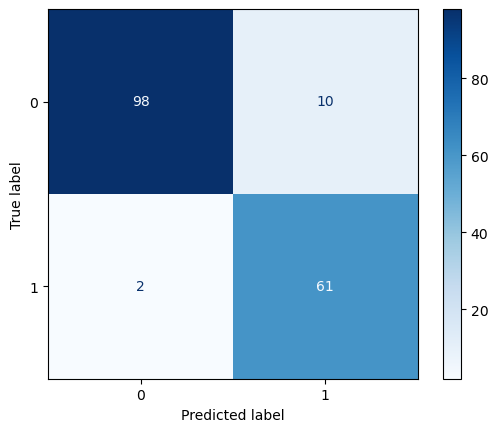

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test_cv, y_pred_final)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm_model.classes_)
cm_display.plot(cmap='Blues')

### Confusion Matrix Interpretation

The confusion matrix shows that out of the 63 malignant cases in the test set, the model correctly identified 61 of them, resulting in a recall (sensitivity) of 96.83%. Only 2 malignant cases were misclassified as benign, representing false negatives — the most critical type of error in cancer prediction.

This low false negative rate is especially important in clinical contexts, as failing to detect a malignant tumor could delay treatment and lead to severe consequences. The high recall indicates that the model is highly sensitive and effective at flagging potentially dangerous cases.

### ROC and AUC

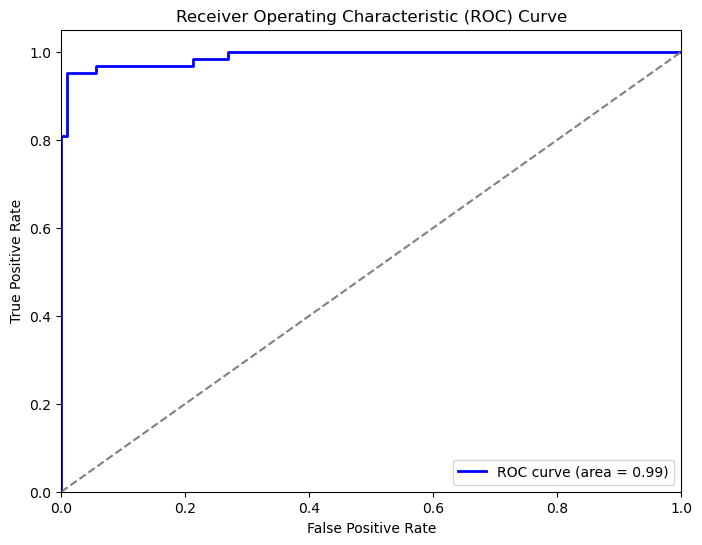

In [38]:
# Import necessary libraries for ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (1) from the SVM model
y_pred_prob = best_svm_model.predict_proba(X_test_cv)[:, 1]  # Get probabilities for the positive class

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_cv, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

sorted_indices = np.argsort(y_pred_prob)[::-1]
sorted_probs = y_pred_prob[sorted_indices]
sorted_true = y_test_cv.iloc[sorted_indices]

### ROC Curve Interpretation

The ROC curve closely hugs the upper-left corner, indicating strong classification performance. The Area Under the Curve (AUC) score of 0.99 suggests that the model can almost perfectly distinguish between the positive and negative classes (meaning it can differntiate between malignant and benign cells).
- A model with AUC = 1.0 is a perfect classifier, while AUC = 0.5 means the model is no better than a coin toss - a random guess
- Testing AUC = 0.99, the model has very strong predictive power
- Below, you will see a training AUC of 0.9980 - which aligns closely with the test performance, suggesting that the model generalizes well and is not overfitting

In [41]:
# Check training AUC to ensure there is no overfitting
# Get predicted probabilities for the positive class (1) from the best SVM model on the training set
y_train_pred_prob = best_svm_model.predict_proba(X_train_cv)[:, 1]  # Get probabilities for the positive class

# Compute ROC curve for training set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_cv, y_train_pred_prob)

# Compute AUC (Area Under the Curve) for training set
roc_auc_train = auc(fpr_train, tpr_train)

# Print the AUC score for the training set
print(f"Training AUC Score: {roc_auc_train:.4f}")

Training AUC Score: 0.9980


### Lift Curve

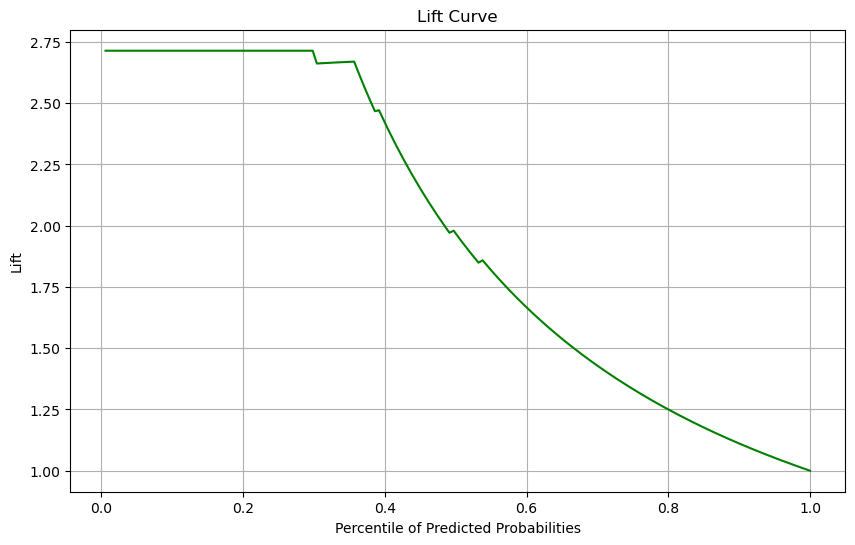

In [43]:
# Calculate cumulative lift
cumulative_true_positive_rate = np.cumsum(sorted_true) / np.sum(sorted_true)
cumulative_all_positive_rate = np.arange(1, len(y_pred_prob) + 1) / len(y_pred_prob)

# Calculate lift (cumulative true positive rate / cumulative all positive rate)
lift = cumulative_true_positive_rate / cumulative_all_positive_rate

# Plot Lift Curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_all_positive_rate, lift, color="g")
plt.xlabel("Percentile of Predicted Probabilities")
plt.ylabel("Lift")
plt.title("Lift Curve")
plt.grid(True)
plt.show()

### Lift Curve Interpretation

When examining the lift curve, the model achieves a lift of approximately 2.72, meaning it is 2.72 times more effective at identifying positive cases (e.g., malignant tumors) than random guessing. This demonstrates that the model is highly reliable in distinguishing between benign and malignant cases, especially in the top-ranked predictions.

A lift greater than 1 indicates better-than-random performance, and a lift of 2.72 reflects a strong concentration of true positives in the top scoring percentile, which is crucial for prioritization in cancer detection tasks.